In [2]:
from importlib import reload
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')
import logging
logging.basicConfig()
LOG = logging.getLogger(__name__)
LOG.info('Hello from notebook')

In [3]:
import frankenfit as ff

logging.getLogger('frankenfit').setLevel(logging.INFO)
#reload(fpc)

In [4]:
ff.DataFramePipeline.clip?

Signature:
ff.DataFramePipeline.clip(
    self,
    cols: 'X',
    upper: 'Optional[float]' = None,
    lower: 'Optional[float]' = None,
    *,
    tag: 'str' = NOTHING,
) -> 'DataFramePipeline'
Docstring:
Return the result of appending a new :class:`Clip` transform
constructed with the given parameters to this pipeline.
This method's arguments are passed directly to
``Clip.__init__()``.

.. SEEALSO:: :class:`Clip`
File:      ~/frankenfit/src/frankenfit/core.py
Type:      function


In [6]:
help(ff.DataFramePipeline.copy)

Help on function copy in module frankenfit.core:

copy(self, cols: 'X', dest_cols: 'X', *, tag: 'str' = NOTHING) -> 'DataFramePipeline'
    Return the result of appending a new :class:`Copy` transform
    constructed with the given parameters to this pipeline.
    This method's arguments are passed directly to
    ``Copy.__init__()``.
    
    .. SEEALSO:: :class:`Copy`



In [7]:
from pydataset import data

In [8]:
df = data('diamonds')
data('diamonds', show_doc=True)

diamonds

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

## Prices of 50,000 round cut diamonds

### Description

A dataset containing the prices and other attributes of almost 54,000
diamonds. The variables are as follows:

### Usage

    data(diamonds)

### Format

A data frame with 53940 rows and 10 variables

### Details

  * price. price in US dollars (\$326–\$18,823) 

  * carat. weight of the diamond (0.2–5.01) 

  * cut. quality of the cut (Fair, Good, Very Good, Premium, Ideal) 

  * colour. diamond colour, from J (worst) to D (best) 

  * clarity. a measurement of how clear the diamond is (I1 (worst), SI1, SI2, VS1, VS2, VVS1, VVS2, IF (best)) 

  * x. length in mm (0–10.74) 

  * y. width in mm (0–58.9) 

  * z. depth in mm (0–31.8) 

  * depth. total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43–79) 

  * table. width of top of diamond relative to widest point (43–95) 




In [9]:
index_all = set(df.index)
index_in = set(np.random.choice(df.index, size=int(len(df)/2), replace=False))
index_out = index_all - index_in
len(index_all), len(index_in), len(index_out)
df_in = df.loc[list(index_in)]
df_out = df.loc[list(index_out)]
df_in.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39
12,0.23,Ideal,J,VS1,62.8,56.0,340,3.93,3.90,2.46


In [10]:
df_out.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53


array([[<AxesSubplot: title={'center': 'price'}>]], dtype=object)

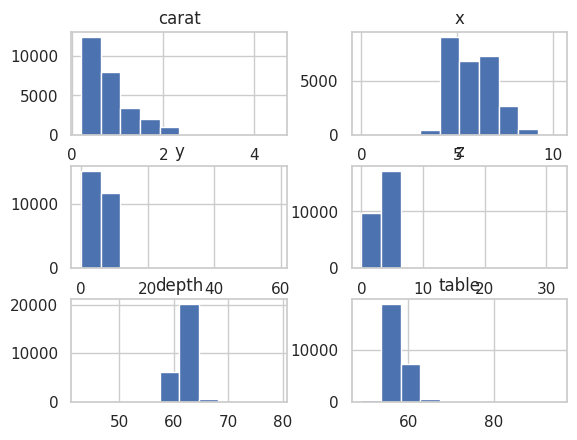

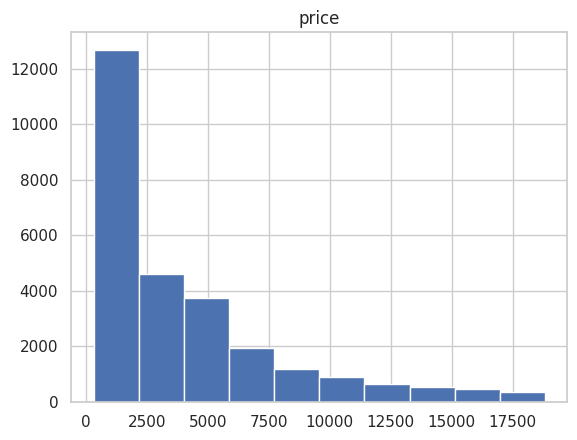

In [11]:
FEATURES = ['carat', 'x', 'y', 'z', 'depth', 'table']
df_in[FEATURES].hist();
df_in[['price']].hist()

In [13]:
# call-chain syntax...

def standardize_callchain(cols):
    return (
        ff.DataFramePipeline()
        .winsorize(cols, limit=0.05)
        .z_score(cols)
        .impute_constant(cols, 0.)
        .clip(cols, upper=2, lower=-2)
    )

FEATURES = ['carat', 'x', 'y', 'z', 'depth', 'table']

pipeline_callchain = (
    ff.DataFramePipeline()
    .copy('price', 'price_train')
    .pipe(['carat', 'price_train'], np.log1p)
    .then(standardize_callchain(FEATURES + ['price_train']))
)

In [15]:
pipeline_callchain

DataFramePipeline(tag='DataFramePipeline#3', transforms=[Copy(tag='Copy#2', cols=['price'], dest_cols=['price_train']), Pipe(tag='Pipe#2', cols=['carat', 'price_train'], apply_fun=<ufunc 'log1p'>), Winsorize(tag='Winsorize#2', cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], limit=0.05), ZScore(tag='ZScore#2', cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], w_col=None), ImputeConstant(tag='ImputeConstant#2', cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], value=0.0), Clip(tag='Clip#2', cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], upper=2, lower=-2)])

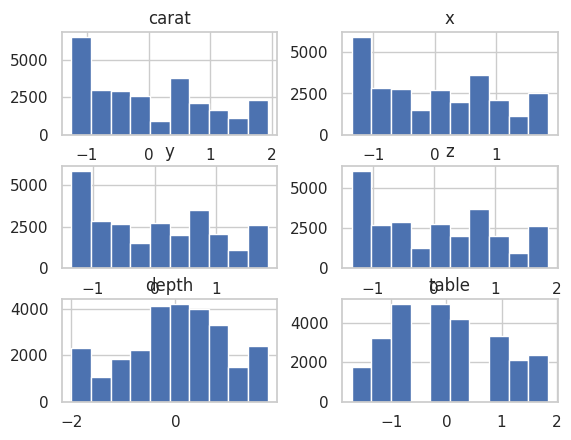

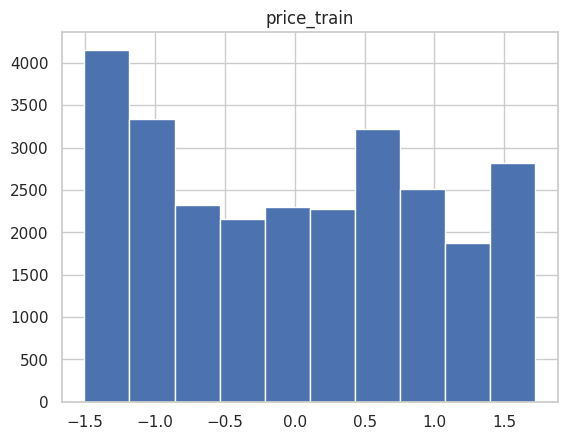

In [16]:
fit_pipeline = pipeline_callchain.fit(df_in)
result_in = fit_pipeline.apply(df_in)

result_in[FEATURES].hist();
result_in[['price_train']].hist();

In [17]:
fit_pipeline.state()

[FitCopy(tag='Copy#2', cols=['price'], dest_cols=['price_train']),
 FitPipe(tag='Pipe#2', cols=['carat', 'price_train'], apply_fun=<ufunc 'log1p'>),
 FitWinsorize(tag='Winsorize#2', cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], limit=0.05),
 FitZScore(tag='ZScore#2', cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], w_col=None),
 FitImputeConstant(tag='ImputeConstant#2', cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], value=0.0),
 FitClip(tag='Clip#2', cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], upper=2, lower=-2)]

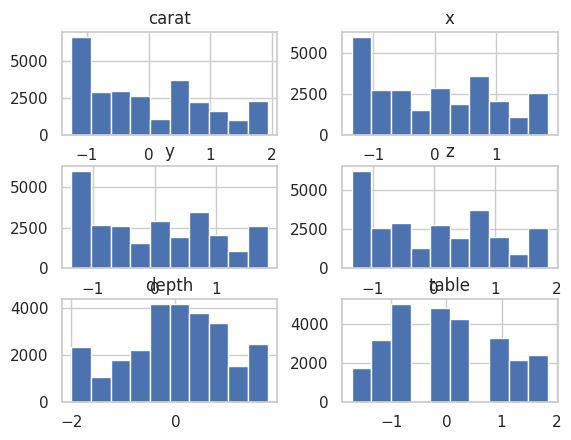

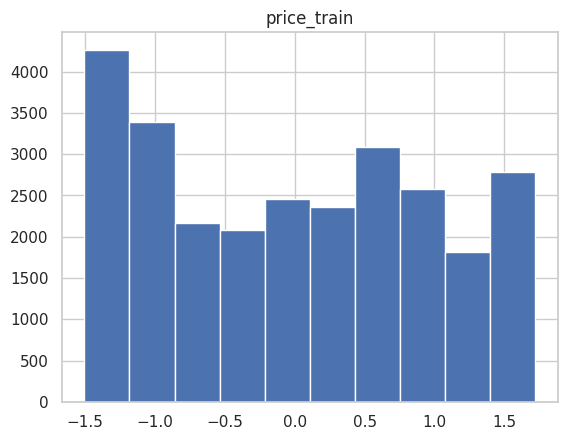

In [18]:
result_out = fit_pipeline.apply(df_out)
result_out[FEATURES].hist();
result_out[['price_train']].hist();

In [19]:
help(ff.DataFramePipeline)

Help on class DataFramePipeline in module frankenfit.dataframe:

class DataFramePipeline(frankenfit.core.DataFramePipeline)
 |  DataFramePipeline(tag=NOTHING, transforms=NOTHING)
 |  
 |  Method resolution order:
 |      DataFramePipeline
 |      frankenfit.core.DataFramePipeline
 |      frankenfit.universal.Pipeline
 |      frankenfit.core.Pipeline
 |      frankenfit.core.ObjectPipeline
 |      frankenfit.core.Transform
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, data_fit: 'object' = None, bindings: 'Optional[dict[str, object]]' = None) -> 'DataFramePipeline.FitDataFramePipeline'
 |      Fit this Transform on some data and return a :class:`FitTransform` object. The
 |      actual return value will be some subclass of ``FitTransform`` that depends on
 |      what class this Transform is; for example, :meth:`ZScore.fit()` returns a
 |      :class:`FitZScore` object.
 |      
 |      :param data_fit: _description_
 |      :type data_fit: Data